**IMPORTANT** - This notebook contains elements that work best with google colab's GPU and environment (including the GloVe dataset). If you want to run the notebook, run it on google colab with the kaggle.json file that I have provided

<h1>My Solution</h1>

Given the unique nature of the dataset, it would be rather ignorant of us to treat it like any generic regression problem, which is why I have implemented both NLP and Regression to solve this problem

My final pipeline includes one main regressor (a word embedding model), and four simple linear regressors to predict all five labels as accurately as possible

Final Pipeline looks something like this
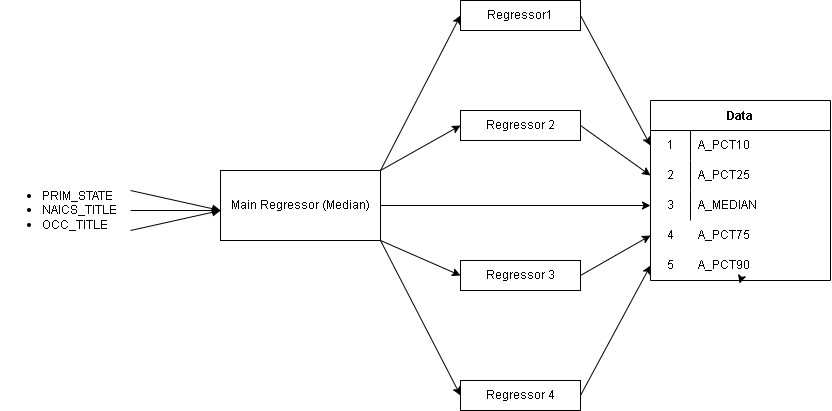


This is what the main regressor looks like - 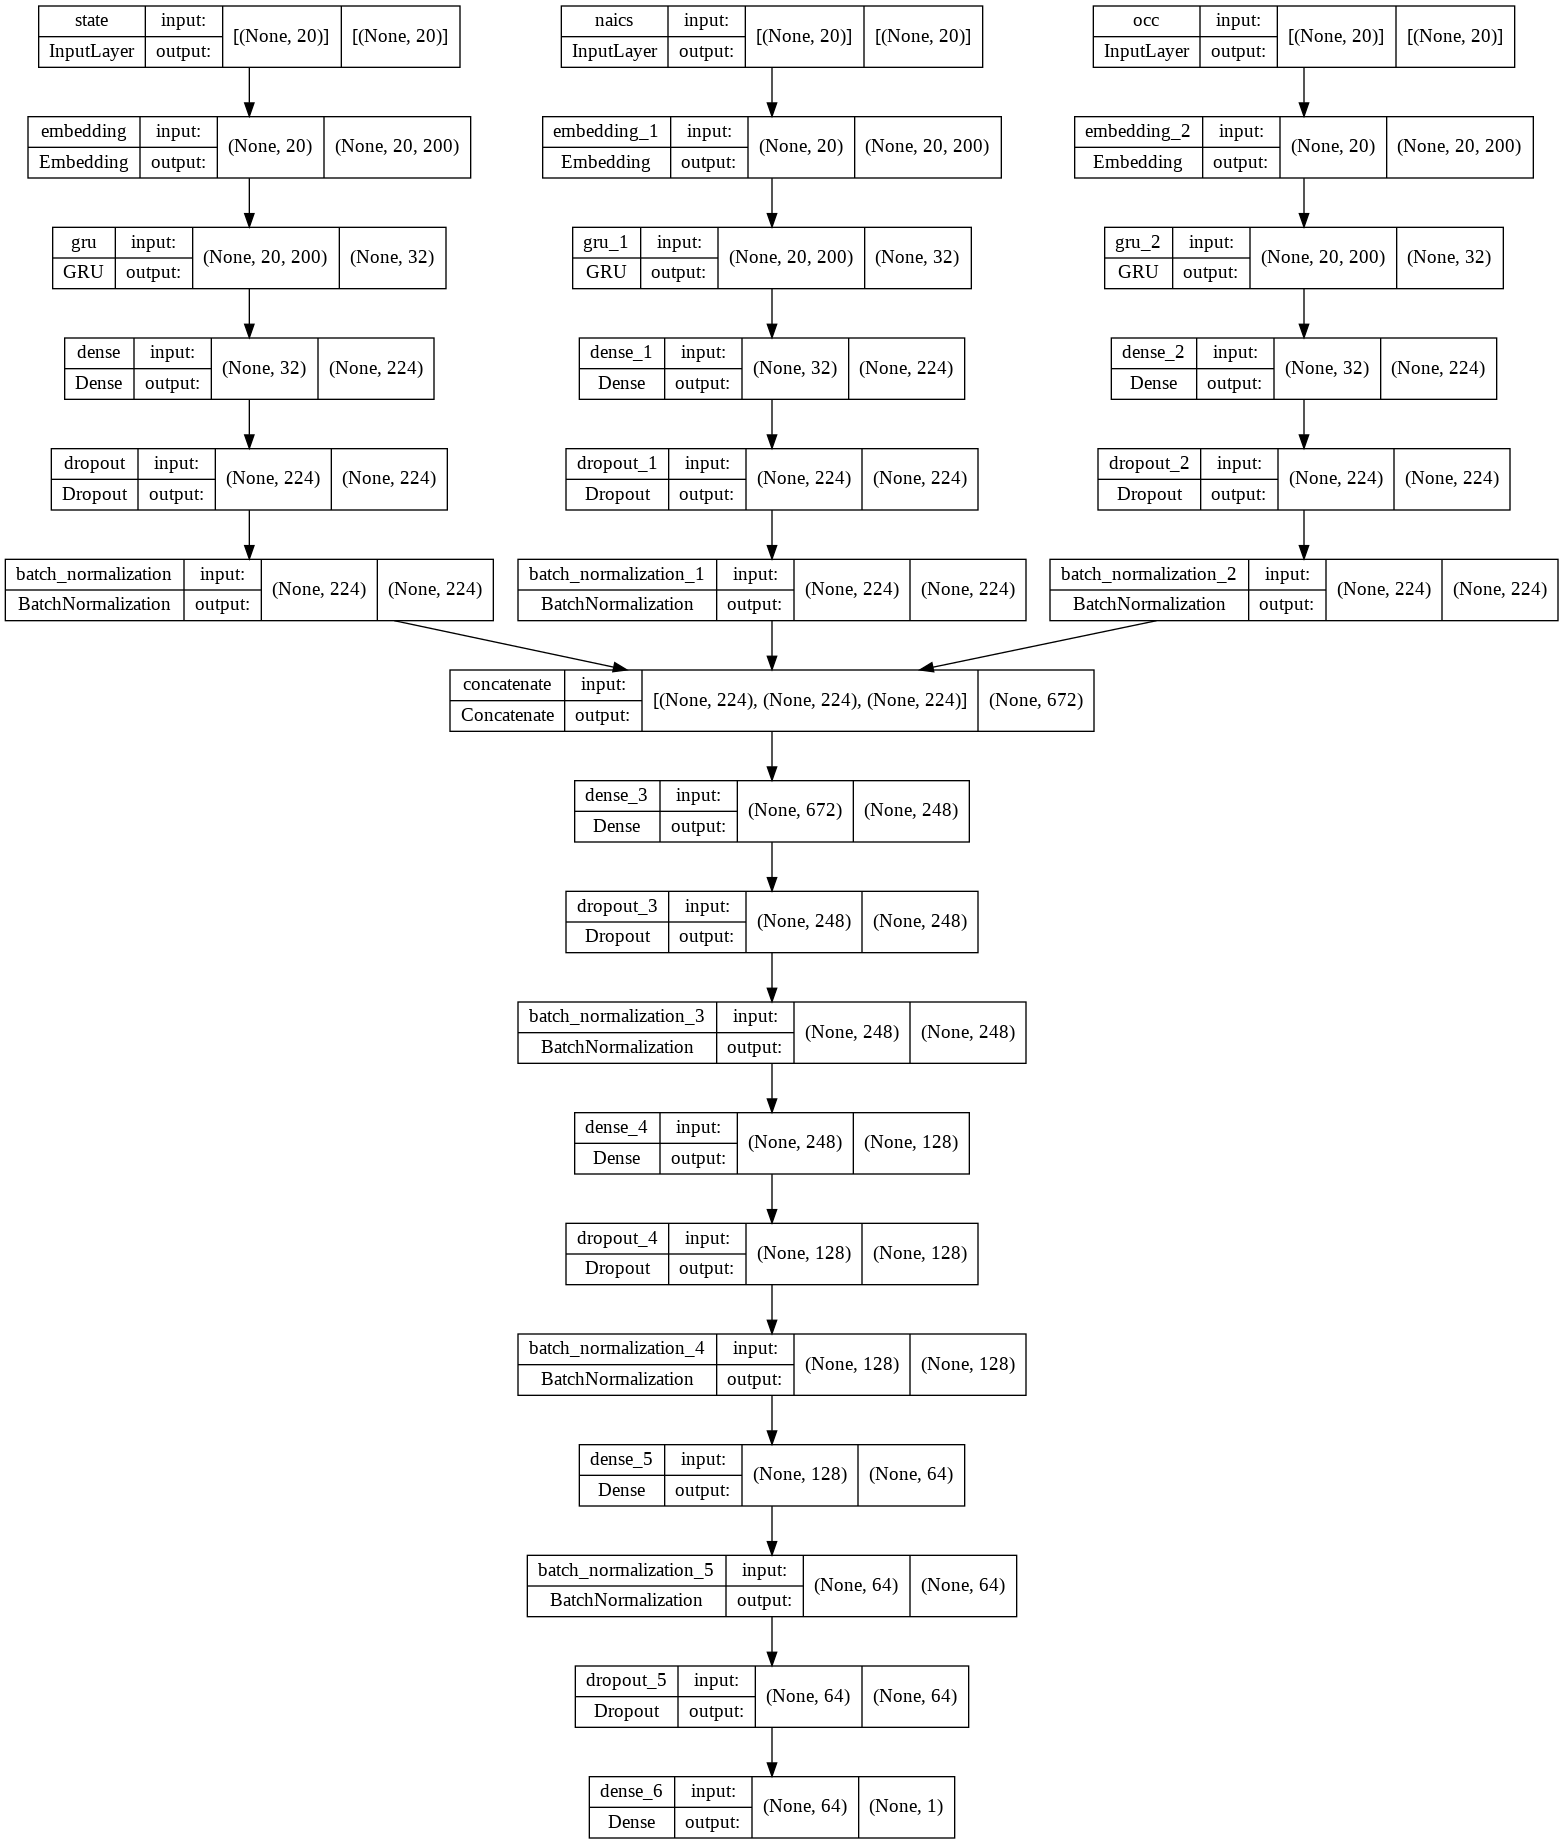

<h1>Methodology</h1>

Our methodology goes something like this-


*   Getting familiar with the dataset
*   Preprocessing and Exploratory Data Analysis
*   Creating the Final Model
*   Predictions



<h1>Part one- Getting familiar with the dataset</h1>
Here we will explore the dataset to get more familiar with its intricacies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('/content/train.csv')
data

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.0
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.0
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.0
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.0
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.0
...,...,...,...,...,...,...,...,...
2292,NJ,Cross-industry,Legal Occupations,47950.0,73720.0,101550.0,163990.0,NaN
2293,NY,Cross-industry,Legal Occupations,47580.0,75920.0,126220.0,NaN,NaN
2294,RI,Cross-industry,Legal Occupations,46400.0,60560.0,98070.0,161120.0,NaN
2295,TX,Cross-industry,Legal Occupations,37540.0,51260.0,80850.0,135490.0,NaN


In [ ]:
#we see a lot of repeating values, which means all features (hopefully) are categorical. Let's check for these categories
print('unique states',data['PRIM_STATE'].nunique())
print('unique industries', data['NAICS_TITLE'].nunique())
print('unique positions', data['OCC_TITLE'].nunique())

unique states 52
unique industries 21
unique positions 116


Our dataset includes three textual features and five label classes. Each of these features include categorical data in the form of a text

This means there are two possible ways to solve the problem- 


1.   Focus on the categories, use different encoding methods and solve it like any other regression problem
2.   Focus on the text itself, use word embeddings and NLP to solve the problem


Let us see if the first solution works for us or not
The first thing we notice is that PRIM_STATE, NAICS_TITLE, and OCC_TITLE can use some preprocessing. Let's start with some basic encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
data['states'] = enc.fit_transform(data['PRIM_STATE'])
data['industries'] = enc.fit_transform(data['NAICS_TITLE'])
data['positions'] = enc.fit_transform(data['OCC_TITLE'])
data.head()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,states,industries,positions
0,US,"Arts, Entertainment, and Recreation",Supervisors of Transportation and Material Mov...,32350.0,40200.0,50790.0,62560.0,78520.0,44,3,108
1,US,"Mining, Quarrying, and Oil and Gas Extraction","Sales Representatives, Wholesale and Manufactu...",47860.0,61600.0,87810.0,107460.0,153600.0,44,13,94
2,US,Finance and Insurance,Physical Scientists,59240.0,63050.0,89740.0,126320.0,149070.0,44,8,83
3,US,Administrative and Support and Waste Managemen...,"Architects, Surveyors, and Cartographers",37320.0,47630.0,60550.0,77450.0,98990.0,44,1,4
4,US,Manufacturing,Supervisors of Protective Service Workers,50130.0,63840.0,81770.0,104530.0,133180.0,44,12,106


In [ ]:
data.tail()

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,states,industries,positions
2292,NJ,Cross-industry,Legal Occupations,47950.0,73720.0,101550.0,163990.0,NaN,31,5,49
2293,NY,Cross-industry,Legal Occupations,47580.0,75920.0,126220.0,NaN,NaN,34,5,49
2294,RI,Cross-industry,Legal Occupations,46400.0,60560.0,98070.0,161120.0,NaN,39,5,49
2295,TX,Cross-industry,Legal Occupations,37540.0,51260.0,80850.0,135490.0,NaN,43,5,49
2296,NJ,Cross-industry,Healthcare Practitioners and Technical Occupat...,46750.0,61680.0,80130.0,119690.0,NaN,31,5,41


One way to test the usefulness of features is the Pearson Coefficient matrix. As the name suggests, it gives us the correlation (p) between features and labels. 

*   If |p|> 0.5, the relation is strong
*   If |p|< 0.29, the relation is weak

Pearson coefficient helps us judge the model features even before putting it in a model, which will save us a lot of time

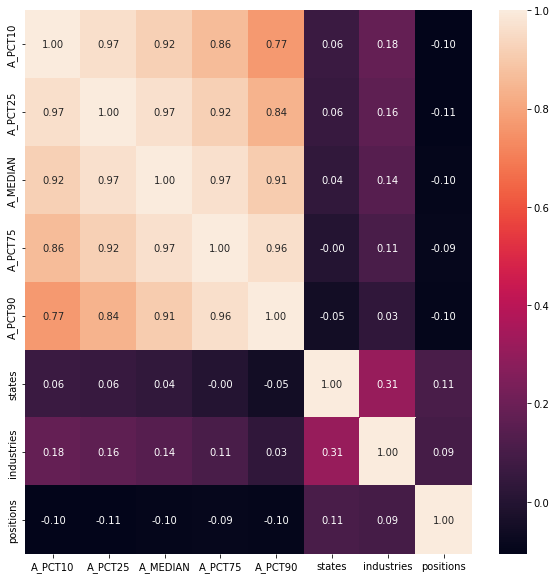

In [ ]:
#let's see if encoding is of some help
import seaborn as sns
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot = True, fmt= '.2f')

This is rather disappointing.As we can see, the correlation values of states, industries, and positions are pretty weak. This means that a regression model such as linear or ridge regression are of no use. So we'll have to use the second method, that is, to use word embeddings

<h1>Words go a long way...</h1>
The current correlation coefficients aren't really helping us much. 
A simple encoder might be of some help, but we need more insights. On that note, let's focus more on the text itself

To understand this method, let us take a human example:

When you talk about a particular state or profession, you instantly get an intuition of what the pay grade is like. For example, when I say  "I'm a Machine Learning Engineer at Hackerrank, in New Delhi", you can kinda guess the annual salary in some way or the other.

So this leads us to the second solution, where we will employ GLoVe word embeddings and some clever regression to solve the problem at hand.

But before that, we need to clean the data...





<h1> Part two - Preprocessing and Exploratory Data Analysis</h1>

In [ ]:
data.info()#you can see that there are a lot of empty values in the dataset, which need to be dealt with

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PRIM_STATE   2297 non-null   object 
 1   NAICS_TITLE  2297 non-null   object 
 2   OCC_TITLE    2297 non-null   object 
 3   A_PCT10      2297 non-null   float64
 4   A_PCT25      2297 non-null   float64
 5   A_MEDIAN     2297 non-null   float64
 6   A_PCT75      2267 non-null   float64
 7   A_PCT90      2158 non-null   float64
 8   states       2297 non-null   int64  
 9   industries   2297 non-null   int64  
 10  positions    2297 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 197.5+ KB


In [ ]:
!pip install impyute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys #we'll use knn imputation to fill in null values in the dataframe
from impyute.imputation.cs import fast_knn
sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# start the KNN training
imputed_training=fast_knn(data[['A_PCT75','A_PCT90']].values, k=30)
data[['A_PCT75','A_PCT90']] = imputed_training
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297 entries, 0 to 2296
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PRIM_STATE   2297 non-null   object 
 1   NAICS_TITLE  2297 non-null   object 
 2   OCC_TITLE    2297 non-null   object 
 3   A_PCT10      2297 non-null   float64
 4   A_PCT25      2297 non-null   float64
 5   A_MEDIAN     2297 non-null   float64
 6   A_PCT75      2297 non-null   float64
 7   A_PCT90      2297 non-null   float64
 8   states       2297 non-null   int64  
 9   industries   2297 non-null   int64  
 10  positions    2297 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 197.5+ KB


Now that our data's clean, it's time to analyse it once again

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3016b40150>,
      dtype=object)

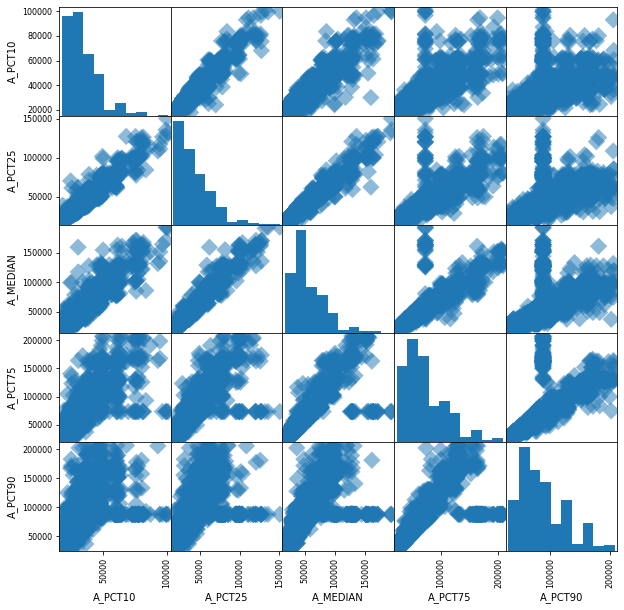

In [ ]:
pd.plotting.scatter_matrix(data[['A_PCT10','A_PCT25','A_MEDIAN','A_PCT75','A_PCT90']], figsize = [10,10], s = 150, marker = 'D')

This scatterplot conveys something very important - there is a (almost) linear relationship between all annual salaries. This observation alone makes our lives easier, and here's how:

If we can accurately predict ONE column, we can also easily predict other columns using a simple Linear Regression algorithm

In [ ]:
import sklearn
#we'll define four models to define the linear relationship with median values
model_10, model_25, model_75, model_90 = sklearn.linear_model.LinearRegression(),sklearn.linear_model.LinearRegression(),sklearn.linear_model.LinearRegression(),sklearn.linear_model.LinearRegression()
#fitting these models
model_10.fit(np.array(data['A_MEDIAN']).reshape(-1,1), np.array(data['A_PCT10']).reshape(-1,1))
model_25.fit(np.array(data['A_MEDIAN']).reshape(-1,1), np.array(data['A_PCT25']).reshape(-1,1))
model_75.fit(np.array(data['A_MEDIAN']).reshape(-1,1), np.array(data['A_PCT75']).reshape(-1,1))
model_90.fit(np.array(data['A_MEDIAN']).reshape(-1,1), np.array(data['A_PCT90']).reshape(-1,1))

LinearRegression()

In [ ]:
sklearn.metrics.mean_absolute_error(model_10.predict(np.array(data['A_MEDIAN']).reshape(-1,1)), data['A_PCT10']) #checkin error

3439.834870752409

This is a bearable amount of error

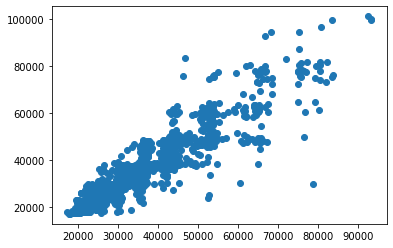

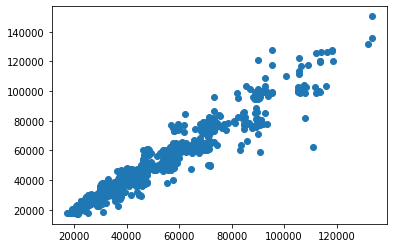

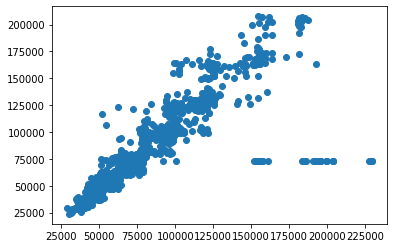

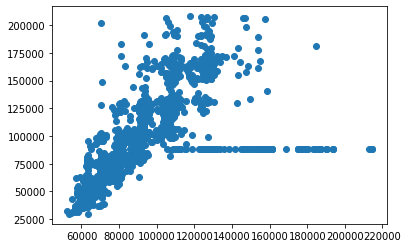

In [ ]:
#let's visualise the prediction accuracy using a couple graphs
for n,i in enumerate([model_10, model_25,None, model_75, model_90]):
 try:
  plt.scatter(i.predict(np.array(data['A_MEDIAN']).reshape(-1,1)),data[data.columns[n+3]])
  plt.show()
 except:
   continue

<h3>As you can see, the graphs are pretty linear (with an exception in the 90th percentile). This is great because now we only need to calculate the median salary, and our linear regression models will handle the rest of our data

<h1>Tokenizing our text</h1>
This step converts the raw text into an integer sequence or a vector that has a coefficient for each token in the form of binary values. This vector will then be fed into our neural network

In [ ]:
state, naics, occ, median_p = [], [],[],[] #saving PRIM_STATE, NAICS_TITLE, OCC_TITLE
for i in data.itertuples():
    state.append(i[1])
    naics.append(i[2])
    occ.append(i[3]) 
    median_p.append(i[-6])

Another very important preprocesing step is to scale our labels. Large numeric values tend to cause gradient explosion in neural networks, so the only workaround is to reduce the range to (0,1] using some scaling algorithm. Here we'll use minmax scaling

In [ ]:
minmax = [] #saving the maximum and minimum median values

minmax.append([min(median_p),max(median_p)])
minmax

[[17940.0, 192900.0]]

In [ ]:
def scaler(x, y):#simple minmax scaler
   return (x-y[0])/(y[1]-y[0])
median_p=  list(map(lambda x: scaler(x,y = minmax[0]),median_p)) #scaled median values

In [ ]:
#Tokenizing ALL text input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(nb_words=250000)
tokenizer.fit_on_texts(state)
state = tokenizer.texts_to_sequences(state)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

state = pad_sequences(state, maxlen= 20)

print('Shape of data tensor:', state.shape)
tokenizer = Tokenizer(nb_words=250000)
tokenizer.fit_on_texts(naics)
naics = tokenizer.texts_to_sequences(naics)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

naics = pad_sequences(naics, maxlen= 20)

print('Shape of data tensor:', naics.shape)
tokenizer = Tokenizer(nb_words=250000)
tokenizer.fit_on_texts(occ)
occ = tokenizer.texts_to_sequences(occ)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

occ = pad_sequences(occ, maxlen= 20)

print('Shape of data tensor:', occ.shape)
#print('shape of output', output.shape)
median_p =np.asarray(median_p)

Found 52 unique tokens.
Shape of data tensor: (2297, 20)
Found 67 unique tokens.
Shape of data tensor: (2297, 20)
Found 175 unique tokens.
Shape of data tensor: (2297, 20)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [ ]:
#creating final training data
import math
indices = np.arange(state.shape[0])
a = [state, naics,occ]
t_samples = math.floor(state.shape[0]*0.8)
v_samples = state.shape[0]-t_samples
for i in a:
  i = np.array(i)
  i = i[indices]
Xt_state = a[0]
Xt_naics = a[1]
Xt_occ = a[2]


<h1>GLoVe Embeddings</h1>

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. . The advantage of GloVe is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors.

We'll use GLoVe 6B 200vec dataset for this task. 

*REMINDER* - To load this dataset you can either comment the below cell and upload the dataset manually(link - https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation), OR run the entire notebook on google colab with the kaggle.json file I've provided

In [ ]:
!mkdir ~/.kaggle/
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation

 98% 449M/458M [00:14<00:00, 40.8MB/s]
100% 458M/458M [00:14<00:00, 33.1MB/s]


In [ ]:
!unzip /content/glove-global-vectors-for-word-representation.zip

Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [ ]:
#importing the dataset
import os
f = open('/content/glove.6B.200d.txt','r+')
embeddings_index = {}
for line in f:
    value = line.split()
    word = value[0]
    coefs = np.asarray(value[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors'%len(embeddings_index))

Found 400000 word vectors


In [ ]:
#creating the final embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((1193514, embedding_dim))
for word, i in word_index.items():
    if i<200:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20327   ,  0.47347999,  0.050877  , ..., -0.21358   ,
        -0.62248999,  0.14386   ],
       [ 0.58724999,  0.082163  ,  0.22414   , ...,  0.26335999,
         0.061366  ,  0.20246001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

<h1>Part Three- Creating the final Model</h1>

We have done all the preprocessing we needed, all that's left is to build and train the model. For our purposes, we'll train a simple RNN with three GRU (Gated Recurrent Unit) heads and A LOT of dense layers. We'll also use Batch Normalization to prevent gradient explosion

In [ ]:

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten, BatchNormalization
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
lrelu = lambda x: tf.keras.layers.LeakyReLU( alpha = 0.1)(x)

def GRUHead(input = None, name = ''):
   model = Embedding(1193514, embedding_dim, input_length = 1000, weights = [embedding_matrix], trainable = True)(input)
   model = GRU(32)(model)
   model = Dense(224, activation= lrelu)(model)
   model = Dropout(0.02)(model)
   model = BatchNormalization()(model)
  # model = keras.Model(inputs=input, outputs=model, name=  name)
   return model
def model():
   state_input = Input(shape = (20,), name = 'state')
   naics_input = Input(shape = (20,), name = 'naics')
   occ_input = Input(shape = (20,), name = 'occ')
   state_layer = GRUHead(input = state_input,name = 'state')
   naics_layer = GRUHead(input = naics_input, name = 'naics')
   occ_layer = GRUHead(input = occ_input, name = 'occ')
   model = keras.layers.concatenate([state_layer, naics_layer, occ_layer])
   model = Dense(248, activation= lrelu)(model)
   model = Dropout(0.02)(model)
   model = BatchNormalization()(model)
   model = Dense(128, activation= lrelu)(model)
   model = Dropout(0.1)(model)
   model = BatchNormalization()(model)
   out1 = Dense(64, activation= lrelu)(model)
   out1 = BatchNormalization()(out1)
   out1 = Dropout(0.06)(out1)
   out1 = Dense(1)(out1)
   model = keras.Model(
    inputs=[state_input, naics_input, occ_input],
    outputs=[out1])
   keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True) #it's a great way of visualizing the model architecture 
   return model

In [ ]:
NLPmodel = model()

In [ ]:
NLPmodel.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=
        keras.losses.Huber(),
    metrics=['mean_squared_error']

)

In [ ]:
#converting training data into arrays
Xt_state = np.asarray(Xt_state)
Xt_naics = np.asarray(Xt_naics)
Xt_occ = np.asarray(Xt_occ)
#fitting the model
NLPmodel.fit(
    x = [ Xt_state, Xt_naics, Xt_occ],y = [median_p], validation_split = 0.4,
    epochs=10,
    batch_size=2
)

Epoch 1/10
689/689 [==============================] - 90s 114ms/step - loss: 0.2708 - mean_squared_error: 0.6113 - val_loss: 0.9220 - val_mean_squared_error: 3.1331
Epoch 2/10
689/689 [==============================] - 77s 111ms/step - loss: 0.0717 - mean_squared_error: 0.1442 - val_loss: 0.5317 - val_mean_squared_error: 1.1990
Epoch 3/10
689/689 [==============================] - 77s 112ms/step - loss: 0.0307 - mean_squared_error: 0.0615 - val_loss: 0.0602 - val_mean_squared_error: 0.1203
Epoch 4/10
689/689 [==============================] - 77s 111ms/step - loss: 0.0137 - mean_squared_error: 0.0274 - val_loss: 0.0393 - val_mean_squared_error: 0.0786
Epoch 5/10
689/689 [==============================] - 77s 111ms/step - loss: 0.0090 - mean_squared_error: 0.0181 - val_loss: 0.0419 - val_mean_squared_error: 0.0841
Epoch 6/10
689/689 [==============================] - 77s 111ms/step - loss: 0.0079 - mean_squared_error: 0.0158 - val_loss: 0.0391 - val_mean_squared_error: 0.0783
Epoch 7/10

<h1> Part Four- Predictions </h1>

Now let us eyeball the performance of our model. Keep in mind that our data has been scaled down, so we'll have to restore it's original value. That's simple because we already know the maximum and minimum values of the median salary.

In this step we will also use the linear regression models that we made earlier

In [ ]:
#prediction
l = NLPmodel.predict([Xt_state,Xt_naics,Xt_occ])
#scaling
l = np.array(list(map(lambda x: (minmax[0][1]-minmax[0][0])*x+minmax[0][0], l)))
#predicting 10th, 25th, 75th and 90th percentile
a, b, d, e = model_10.predict(l), model_25.predict(l), model_75.predict(l), model_90.predict(l)
conca = np.concatenate((a,b,l,d,e), axis = 1)
print(conca.shape)
#saving as a pandas dataframe
df = pd.DataFrame(conca, columns = data.columns[[3,4,5,6,7]])
df.head()

(2297, 5)


,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,24609.017423,28618.574200,34881.375000,48363.153875,68143.861363
1,16310.323813,15957.939618,15774.294922,26493.194512,50475.224209
2,42357.372514,55695.780424,75745.546875,95136.275390,105931.645918
3,34581.901259,43833.383172,57843.144531,74645.189879,89376.994453
4,22447.988940,25321.670708,29905.779297,42668.088204,63542.844633


Now we will just copy the above code for the submission file to make our final predictions

In [ ]:
solution = pd.read_csv('/content/submission.csv')
state, naics, occ = [], [],[]
for i in solution.itertuples():
    state.append(i[1])
    naics.append(i[2])
    occ.append(i[3]) 

tokenizer = Tokenizer(nb_words=250000)
tokenizer.fit_on_texts(state)
state = tokenizer.texts_to_sequences(state)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

state = pad_sequences(state, maxlen= 20)

print('Shape of data tensor:', state.shape)
tokenizer = Tokenizer(nb_words=250000)
tokenizer.fit_on_texts(naics)
naics = tokenizer.texts_to_sequences(naics)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

naics = pad_sequences(naics, maxlen= 20)

print('Shape of data tensor:', naics.shape)
tokenizer = Tokenizer(nb_words=250000)
tokenizer.fit_on_texts(occ)
occ = tokenizer.texts_to_sequences(occ)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

occ = pad_sequences(occ, maxlen= 20)

print('Shape of data tensor:', occ.shape)
import math
indices = np.arange(state.shape[0])
a = [state, naics,occ]
t_samples = math.floor(state.shape[0]*0.8)
v_samples = state.shape[0]-t_samples
for i in a:
  i = np.array(i)
  i = i[indices]
state = a[0]
naics = a[1]
occ = a[2]
l = NLPmodel.predict([state,naics,occ])
l = np.array(list(map(lambda x: (minmax[0][1]-minmax[0][0])*x+minmax[0][0], l)))
a, b, d, e = model_10.predict(l), model_25.predict(l), model_75.predict(l), model_90.predict(l)
conca = np.concatenate((a,b,l,d,e), axis = 1)
print(conca.shape)
df = pd.DataFrame(conca, columns = data.columns[[3,4,5,6,7]])
df.head()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 52 unique tokens.
Shape of data tensor: (926, 20)
Found 67 unique tokens.
Shape of data tensor: (926, 20)
Found 173 unique tokens.
Shape of data tensor: (926, 20)
(926, 5)


,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,21054.853170,23196.277998,26698.195312,38996.688330,60576.737968
1,18961.321598,20002.348991,21878.005859,33479.500615,56119.428002
2,35604.135709,45392.922232,60196.757812,77339.135087,91553.420097
3,29123.977718,35506.677936,45276.710938,60261.652944,77756.602714
4,18372.470273,19103.986937,20522.222656,31927.671480,54865.712553


In [ ]:
solution[['A_PCT10',	'A_PCT25',	'A_MEDIAN',	'A_PCT75',	'A_PCT90']] = df
solution.head()
#This is our final solution

,PRIM_STATE,NAICS_TITLE,OCC_TITLE,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,US,Accommodation and Food Services,Other Production Occupations,21054.853170,23196.277998,26698.195312,38996.688330,60576.737968
1,NE,Cross-industry,"Arts, Design, Entertainment, Sports, and Media...",18961.321598,20002.348991,21878.005859,33479.500615,56119.428002
2,US,Manufacturing,Construction and Extraction Occupations,35604.135709,45392.922232,60196.757812,77339.135087,91553.420097
3,US,Wholesale Trade,Material Moving Workers,29123.977718,35506.677936,45276.710938,60261.652944,77756.602714
4,US,Other Services (except Public Administration),Supervisors of Building and Grounds Cleaning a...,18372.470273,19103.986937,20522.222656,31927.671480,54865.712553


In [ ]:
solution.to_csv('/content/submission.csv') #saving 